# Inference and Visualization Tutorial

Welcome to the inference and visualization notebook! At this point, you should have a trained model and tiles to run inference. In this notebook we will run inference on a slide and visualize the results. Here are the steps we will review:

- Run inference with a trained model.
- Visualize the inference results

## Run inference with a trained model

Often tissue-based analysis on whole slide images benefit from annotations provided by expert pathologists. However, having pathologists annotate 1000s of slides is very time consuming and expensive. To overcome this bottleneck, it is common to have pathologist annotate a subset of the slides, and use that dataset to train a model. This model is then used to label the rest of the dataset.

In the model training notebook, we trained a ResNet-18 model on a subset of our slides with the annotated regions and labels. We will now use this trained model and the prepared tiles from the test slide to run the inference step.

In [5]:
import os
HOME = os.environ['HOME']

In [6]:
env DATASET_URL=file:///$HOME/vmount/PRO-12-123/

env: DATASET_URL=file:////home/pashaa/vmount/PRO-12-123/


In [7]:
!infer_tiles --help

2022-08-24 13:15:51,437 - INFO - root - Initalized logger, log file at: luna.log
Usage: infer_tiles [OPTIONS] INPUT_SLIDE_TILES

  Run a model with a specific pre-transform for all tiles in a slide
  (tile_images), requires tiles to be saved (save_tiles) first

  Inputs:
      input_slide_tiles: path to tile images (.tiles.csv)
  
  Outputs:
      tile_scores
  
  Example:
      infer_tiles tiles/slide-100012/tiles
          -rn msk-mind/luna-ml:main
          -mn tissue_tile_net_model_5_class
          -tn tissue_tile_net_transform
          -wt main:tissue_net_2021-01-19_21.05.24-e17.pth
          -o tiles/slide-100012/scores

Options:
  -o, --output_dir TEXT         path to output directory to save results
  -rn, --hub_repo_or_dir TEXT   repository name to pull model and weight from,
                                e.g. msk-mind/luna-ml
  -mn, --model_name TEXT        torch hub model name
  -kw, --kwargs TEXT            additional keywords to pass to model
                        

`infer_tiles` CLI takes in details on your trained model, and loads the tiles data for inference.

First we need to copy the model checkpoint into the `classifier` directory where we have a `hubconf.py` file that defines the model settings. 



In [4]:
! cp ../PRO-12-123/tissue_classifier_results/checkpoint_1.pt ~/vmount/classifier/model.checkpoint 

Next, we need to generate tiles for the slides we want to compute predictions on. Previously, we only generated tiles for portions of the whole slide that contained annotations. Now, we want to tile the entire slide and only remove tiles that have background/glass and keep all of tiles containing tissue. 

Just like before, the pipeline is to first `generate_tiles` for a particular slide, then to run `detect_tissue` to remove glass using an otsu threshold, and then to `save_tiles`, which we can use for inference. 

In [5]:
!generate_tiles \
file:~/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs \
--tile_size 128 --requested_magnification 20 \
-o ~/vmount/PRO-12-123/tiling/inference/tiles

2022-08-22 13:03:07,479 - INFO - root - Initalized logger, log file at: luna.log
2022-08-22 13:03:09,177 - INFO - luna.common.utils - Started CLI Runner wtih <function generate_tiles at 0x7f059c923dc0>
2022-08-22 13:03:09,178 - INFO - luna.common.utils - Validating params...
2022-08-22 13:03:09,180 - INFO - luna.common.utils -  -> Set input_slide_image (<class 'str'>) = file:~/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs
2022-08-22 13:03:09,181 - INFO - luna.common.utils -  -> Set output_dir (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/tiling/inference/tiles
2022-08-22 13:03:09,181 - INFO - luna.common.utils -  -> Set tile_size (<class 'int'>) = 128
2022-08-22 13:03:09,182 - INFO - luna.common.utils -  -> Set requested_magnification (<class 'float'>) = 20.0
2022-08-22 13:03:09,183 - INFO - luna.common.utils - Expanding inputs...
2022-08-22 13:03:09,184 - INFO - luna.common.utils - Attempting to read metadata at file:~/vmount/PRO-12-123/data/toy_dat

In [9]:
!detect_tissue \
~/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs \
~/vmount/PRO-12-123/tiling/inference/tiles \
--requested_magnification 2 \
--filter_query "(otsu_score > 0.1) & (purple_score > 0.1)" \
-o ~/vmount/PRO-12-123/tiling/inference/detect

2022-08-24 13:29:42,839 - INFO - root - Initalized logger, log file at: luna.log
2022-08-24 13:29:45,145 - INFO - luna.common.utils - Started CLI Runner wtih <function detect_tissue at 0x7f2d4991c310>
2022-08-24 13:29:45,147 - INFO - luna.common.utils - Validating params...
2022-08-24 13:29:45,149 - INFO - luna.common.utils -  -> Set input_slide_image (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs
2022-08-24 13:29:45,151 - INFO - luna.common.utils -  -> Set input_slide_tiles (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/tiling/inference/tiles
2022-08-24 13:29:45,153 - INFO - luna.common.utils -  -> Set requested_magnification (<class 'float'>) = 2.0
2022-08-24 13:29:45,156 - INFO - luna.common.utils -  -> Set filter_query (<class 'str'>) = (otsu_score > 0.1) & (purple_score > 0.1)
2022-08-24 13:29:45,158 - INFO - luna.common.utils -  -> Set output_dir (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/tiling/inference/dete

In [7]:
!save_tiles \
~/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs \
~/vmount/PRO-12-123/tiling/inference/detect \
--num_cores 16 --batch_size 200 --dataset_id PRO_TILES_INFERENCE \
-o ~/vmount/PRO-12-123/tiling/inference/saved_tiles

2022-08-22 13:05:55,866 - INFO - root - Initalized logger, log file at: luna.log
2022-08-22 13:05:58,685 - INFO - luna.common.utils - Started CLI Runner wtih <function save_tiles at 0x7fa96c1d4dc0>
2022-08-22 13:05:58,688 - INFO - luna.common.utils - Validating params...
2022-08-22 13:05:58,690 - INFO - luna.common.utils -  -> Set input_slide_image (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs
2022-08-22 13:05:58,692 - INFO - luna.common.utils -  -> Set input_slide_tiles (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/tiling/inference/detect
2022-08-22 13:05:58,694 - INFO - luna.common.utils -  -> Set output_dir (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/tiling/inference/saved_tiles
2022-08-22 13:05:58,696 - INFO - luna.common.utils -  -> Set num_cores (<class 'int'>) = 16
2022-08-22 13:05:58,697 - INFO - luna.common.utils -  -> Set batch_size (<class 'int'>) = 200
2022-08-22 13:05:58,704 - INFO - luna.common.utils 

Now that we have a set of saved tiles, we can run inference by specifying the dataset of saved tiles and some parameters about our model. 

In [1]:
!infer_tiles ~/vmount/PRO-12-123/datasets/PRO_TILES_INFERENCE/ \
--output_dir ../PRO-12-123/sample_tiles_inference \
--hub_repo_or_dir ~/vmount/classifier \
--model_name 'tissue_classifier' \
--num_cores 4 \
--batch_size 16 \
-kw "{'network':'torchvision.models.resnet18', 'num_labels': 3}"

2022-08-22 13:16:27,361 - INFO - root - Initalized logger, log file at: luna.log
2022-08-22 13:16:27,364 - INFO - luna.common.utils - Started CLI Runner wtih <function infer_tile_labels at 0x7f63da2f74c0>
2022-08-22 13:16:27,365 - INFO - luna.common.utils - Validating params...
2022-08-22 13:16:27,366 - INFO - luna.common.utils -  -> Set input_slide_tiles (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/datasets/PRO_TILES_INFERENCE/
2022-08-22 13:16:27,368 - INFO - luna.common.utils -  -> Set output_dir (<class 'str'>) = ../PRO-12-123/sample_tiles_inference
2022-08-22 13:16:27,369 - INFO - luna.common.utils -  -> Set hub_repo_or_dir (<class 'str'>) = /home/pashaa/vmount/classifier
2022-08-22 13:16:27,370 - INFO - luna.common.utils -  -> Set model_name (<class 'str'>) = tissue_classifier
2022-08-22 13:16:27,372 - INFO - luna.common.utils -  -> Set kwargs (<class 'dict'>) = {'network': 'torchvision.models.resnet18', 'num_labels': 3}
2022-08-22 13:16:27,373 - INFO - luna.common.utils -  -

The output of the inference is saved in a paquet file. Let's take a look at the results.


In [10]:
!ls -lhtr ../PRO-12-123/sample_tiles_inference 

total 612K
-rw-r--r-- 1 root root 608K Aug 22 13:22 tile_scores_and_labels_pytorch_inference.parquet
-rw-r--r-- 1 root root  683 Aug 22 13:22 metadata.yml


In [11]:
import pandas as pd

results = pd.read_parquet("../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.parquet")

display(results)

,index,SEGMENT_ID,slide_id,x_coord,y_coord,xy_extent,tile_size,tile_units,otsu_score,tile_store,0,1,2
address,,,,,,,,,,,,,
x3_y58_z20.0,0,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,768,14848,256,128,px,0.16,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-3.729926,0.452461,2.405580
x6_y171_z20.0,1,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,1536,43776,256,128,px,0.16,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-3.705862,0.379482,2.122864
x6_y172_z20.0,2,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,1536,44032,256,128,px,0.47,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,0.146194,1.245052,-3.456172
x6_y173_z20.0,3,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,1536,44288,256,128,px,0.45,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-0.598081,1.784298,-2.994359
x6_y174_z20.0,4,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,1536,44544,256,128,px,0.35,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-0.951014,0.724427,-1.108024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
x188_y118_z20.0,19977,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,48128,30208,256,128,px,0.21,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-1.543887,0.921025,-0.817754
x193_y206_z20.0,19978,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,49408,52736,256,128,px,0.14,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-2.580429,1.018942,0.388751
x200_y167_z20.0,19979,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,01OV002-bd8cdc70-3d46-40ae-99c4-90ef77,51200,42752,256,128,px,0.15,/home/pashaa/vmount/PRO-12-123/tiling/inferenc...,-2.941179,1.234014,-0.017923


## Visualize the inference results 

Now we will visualize the inference results. **visualize_tiles_png** CLI creates heatmaps based on the scores, and saves the thumbnail images in png format.


In [12]:
!visualize_tiles_png --help

2022-08-29 11:13:36,016 - INFO - root - Initalized logger, log file at: luna.log
Usage: visualize_tiles_png [OPTIONS] INPUT_SLIDE_IMAGE INPUT_SLIDE_TILES

  Generate nice tile markup images with continuous or discrete tile scores

  Inputs:
      input_slide_image: slide image (virtual slide formats compatible with openslide, .svs, .tif, .scn, ...)
      input_slide_tiles: slide tiles (manifest tile files, .tiles.csv)
 
  Outputs:
      markups: markup images
 
  Example:
      visualize_tiles_png 10001.svs 10001/tiles/10001.tiles.csv
          -o 10001/markups
          -pl Tumor,Stroma,TILs,otsu_score
          -rmg 0.5

Options:
  -o, --output_dir TEXT           path to output directory to save results
  -pl, --plot_labels TEXT         Label names (as column labels) to plot
  -rmg, --requested_magnification TEXT
                                  Magnificiation scale at which to generate
                                  thumbnail/png images (recommended <= 1)
  --mpp-units          

If you want to evaluate your model results in detail, it is desirable to review the results and images in high-magnification.
We use [Digital Slide Archive (DSA)](https://digitalslidearchive.github.io/digital_slide_archive/) viewer to examine the high resolution image and results. DSA is a web-based platform and this enables us to easily share the images and model results with other researchers via a link.

A set of CLIs are available to help you convert your pathologist or model-generated annotations and push them to DSA. Please refer to the `dsa-tools.ipynb` notebook for more details.


In [13]:
!visualize_tiles_png \
~/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs \
../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.parquet \
--output_dir ../PRO-12-123/sample_tiles_viz \
--plot_labels 0 \
--requested_magnification 1


2022-08-29 11:14:20,199 - INFO - root - Initalized logger, log file at: luna.log
2022-08-29 11:14:22,055 - INFO - luna.common.utils - Started CLI Runner wtih <function visualize_tiles at 0x7f0550088ee0>
2022-08-29 11:14:22,056 - INFO - luna.common.utils - Validating params...
2022-08-29 11:14:22,058 - INFO - luna.common.utils -  -> Set input_slide_image (<class 'str'>) = /home/pashaa/vmount/PRO-12-123/data/toy_data_set/01OV002-bd8cdc70-3d46-40ae-99c4-90ef77.svs
2022-08-29 11:14:22,061 - INFO - luna.common.utils -  -> Set input_slide_tiles (<class 'str'>) = ../PRO-12-123/sample_tiles_inference/tile_scores_and_labels_pytorch_inference.parquet
2022-08-29 11:14:22,062 - INFO - luna.common.utils -  -> Set mpp_units (<class 'bool'>) = False
2022-08-29 11:14:22,064 - INFO - luna.common.utils -  -> Set plot_labels (typing.List[str]) = ['0']
2022-08-29 11:14:22,066 - INFO - luna.common.utils -  -> Set requested_magnification (<class 'float'>) = 1.0
2022-08-29 11:14:22,067 - INFO - luna.common.u

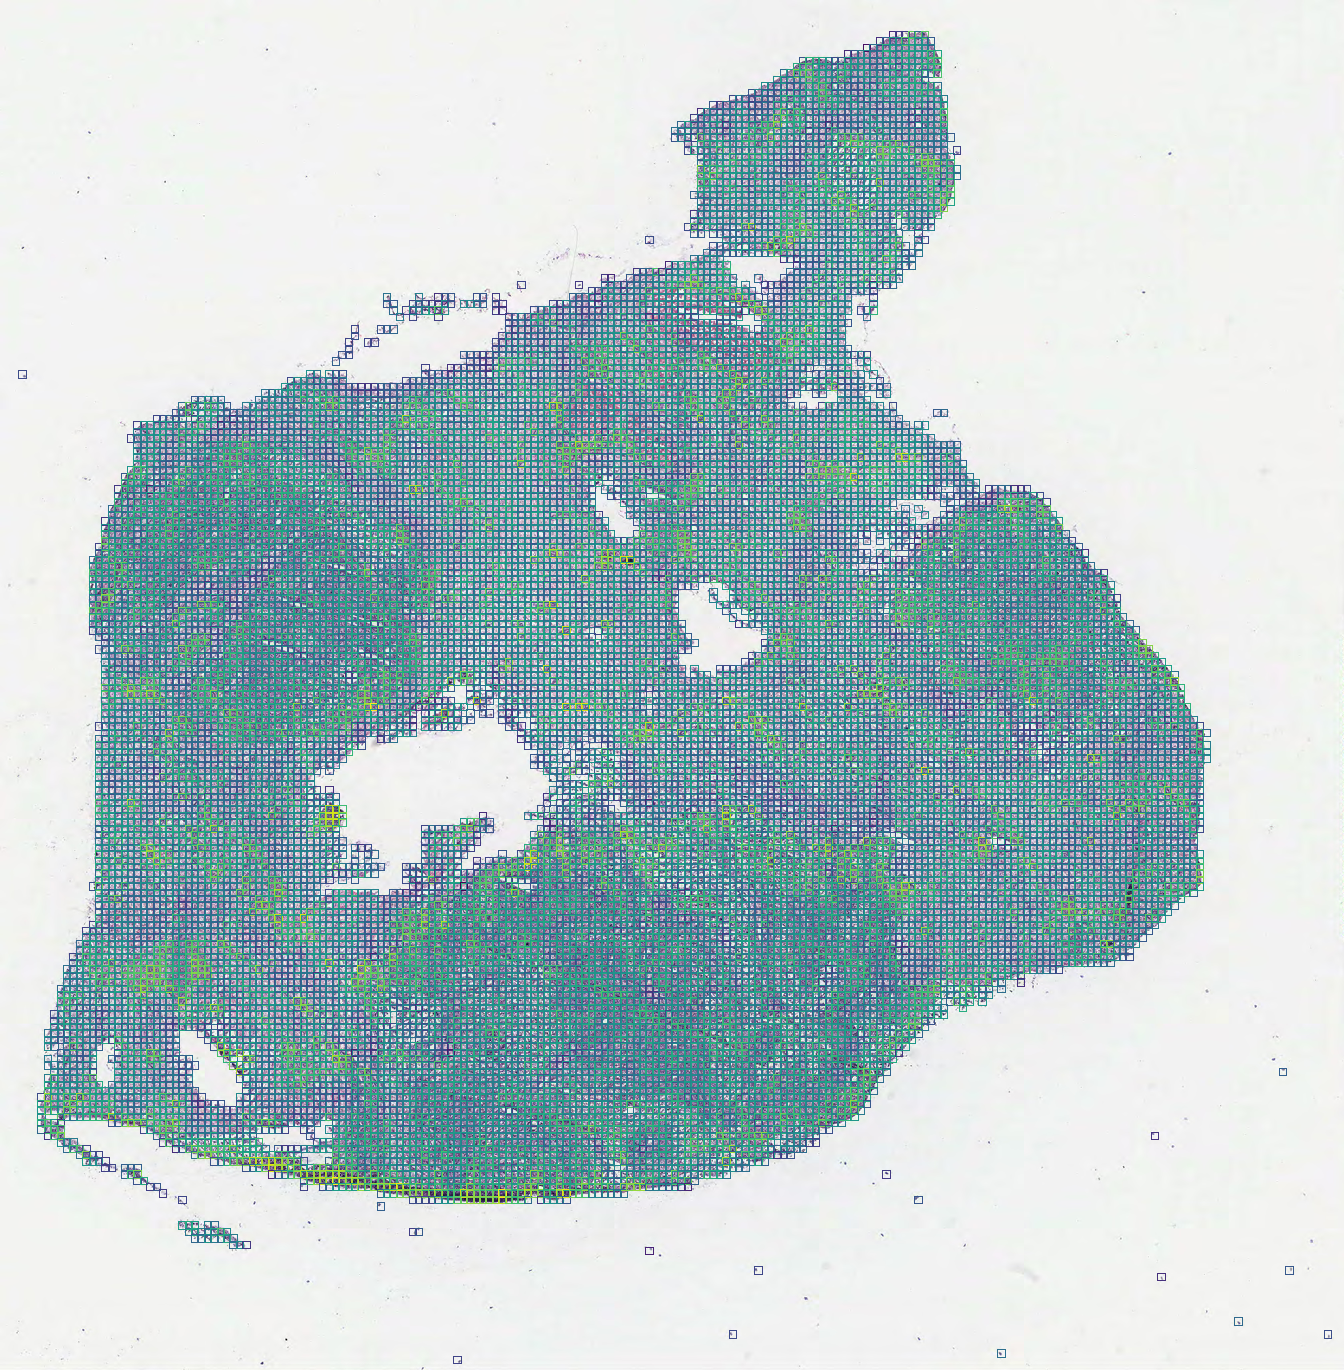

In [4]:
from IPython.display import Image

Image('../PRO-12-123/sample_tiles_viz/tile_scores_and_labels_visualization_0.png')

Congratulations on completing the inference and visualization notebook! To view the end-to-end pipeline of the tiling workflow, please checkout the end-to-end notebook.